# accessing data

In [193]:
# !ls
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib
# !pip install xarray
# !pip install gcsfs
# !pip install tqdm
# !pip install numpy

In [194]:
# Importing their table

import pandas as pd
df = pd.read_csv("/Users/alexanderfeil/Desktop/studies/2 Master/2 Fall Term/machine learning/project/the paper/FPA-FOD_39attributes.csv", low_memory = False)
df = df[~df['NWCG_GENERAL_CAUSE'].str.contains('Missing data/not specified/undetermined', na=False)]
df["NWCG_GENERAL_CAUSE"].value_counts()

NWCG_GENERAL_CAUSE
Natural                                       3948
Debris and open burning                       1088
Arson/incendiarism                             953
Recreation and ceremony                        875
Equipment and vehicle use                      349
Power generation/transmission/distribution     154
Smoking                                         86
Fireworks                                       82
Railroad operations and maintenance             50
Misuse of fire by a minor                       44
Other causes                                    28
Firearms and explosives use                     13
Name: count, dtype: int64

# Processing data

In [195]:
unknown_mask = df['NWCG_GENERAL_CAUSE'] == "Missing data/not specified/undetermined"

df_known = df[~unknown_mask].copy()
df_unknown = df[unknown_mask].copy()

In [196]:
X = df_known.drop(columns=['NWCG_GENERAL_CAUSE'])
y = df_known['NWCG_GENERAL_CAUSE']

In [197]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y) #encode the textual output

# Splitting the data into train and test sets

In [198]:
from sklearn.model_selection import train_test_split

# Combine X and y into one DataFrame temporarily
df3 = X.copy()

df3['cause'] = y_encoded

# Split back into X and y
X = df3.drop(columns=['cause'])
y = df3['cause']

# Now do your train-test split as usual
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

if isinstance(y_train_df, pd.Series):
    y_train_df = y_train_df.to_frame(name='cause')

if isinstance(y_test_df, pd.Series):
    y_test_df = y_test_df.to_frame(name='cause')

### Adding Cause Names

In [199]:
cause_names = [
    "Debris and open burning",
    "Misuse of fire by a minor",
    "Equipment and vehicle use",
    "Fireworks",
    "Arson/incendiarism",
    "Power generation/transmission/distribution",
    "Railroad operations and maintenance",
    "Recreation and ceremony",
    "Natural",
    "Smoking",
    "Other causes",
    "Firearms and explosives use"
]

# Convert y_train value counts into a DataFrame for easier mapping
counts = y_train_df.value_counts().reset_index()
counts.columns = ['cause_id', 'count']


# Map encoded ID to name
counts['cause_name'] = counts['cause_id'].map(lambda i: cause_names[i])



print(counts[['cause_id', 'cause_name', 'count']].to_string(index=False))

 cause_id                                 cause_name  count
        6        Railroad operations and maintenance   3159
        1                  Misuse of fire by a minor    871
        0                    Debris and open burning    762
       10                               Other causes    700
        2                  Equipment and vehicle use    279
        8                                    Natural    123
       11                Firearms and explosives use     69
        4                         Arson/incendiarism     66
        9                                    Smoking     40
        5 Power generation/transmission/distribution     35
        7                    Recreation and ceremony     22
        3                                  Fireworks     10


In [200]:
# Standardization
numeric_cols = X_train_df.select_dtypes(include=['number']).columns

# Compute mean and std only on numeric columns
mean = X_train_df[numeric_cols].mean()
std = X_train_df[numeric_cols].std()

# Standardize numeric columns in place
X_train_df[numeric_cols] = (X_train_df[numeric_cols] - mean) / std
X_test_df[numeric_cols] = (X_test_df[numeric_cols] - mean) / std


# y_train_df = pd.get_dummies(y_train_df).astype(float)
# y_test_df = pd.get_dummies(y_test_df).astype(float)

y_train_df2 = pd.get_dummies(y_train_df['cause'].astype(str)).astype(float)
y_test_df2 = pd.get_dummies(y_test_df['cause'].astype(str)).astype(float)
y_test_df2.head()

,0,1,10,11,2,3,4,5,6,7,8,9
8527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7418,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1413,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [201]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# # Convert sparse matrices to dense arrays
X_train = X_train_df[numeric_cols].to_numpy()
X_test = X_test_df[numeric_cols].to_numpy()
y_train = y_train_df2.to_numpy()


In [202]:
import torch 

# Convert to PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
test_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_test))


# Split into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Neural Network

In [203]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr

import torch
import torch.nn as nn
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cwd = os.getcwd()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
# set hyperparameters
n_neuron       = 128
activation     = 'ReLU' #'ReLU' #'Linear', 'Tanh'
num_epochs     = 50
learning_rate  = 0.0005
minibatch_size = 64
N_layers       = 2 # number of hidden layers
dropout_p = 0.1 #0.1 #sets probability for dropouts
weight_decay = 5e-5



In [357]:
# Create data loaders for batched training
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=minibatch_size, shuffle=False)

In [358]:

layers = []
layers.append(nn.Linear(X_train.shape[1], n_neuron))
layers.append(getattr(nn, activation)())
layers.append(nn.Dropout(dropout_p))   # <- dropout after first activation

for n in range(N_layers-1):
   layers.append(nn.Linear(n_neuron, n_neuron))
   layers.append(getattr(nn, activation)())
   layers.append(nn.Dropout(dropout_p))

layers.append(nn.Linear(n_neuron, y_train.shape[1]))

model = nn.Sequential(*layers)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay  # L2 regularization
    )
criterion = nn.MSELoss()
model.to(device)

Sequential(
  (0): Linear(in_features=38, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=12, bias=True)
)

### Single Neural Network

In [359]:
best_val_loss = float('inf')
patience_counter = 0
patience = 20

train_losses = []
val_losses = []

for epoch in range(num_epochs):
   # training
   model.train()
   train_loss = 0.0
   for batch_X, batch_y in train_loader:
       batch_X = batch_X.to(device)
       batch_y = batch_y.to(device)
       # forward pass
       optimizer.zero_grad()
       outputs = model(batch_X)
       loss = criterion(outputs, batch_y)
       # backward pass
       loss.backward()
       optimizer.step()
       train_loss += loss.item()

    # validation
   model.eval()
   val_loss = 0.0
   with torch.no_grad():
       for batch_X, batch_y in val_loader:
           batch_X = batch_X.to(device)
           batch_y = batch_y.to(device)
           
           outputs = model(batch_X)
           loss = criterion(outputs, batch_y)
           val_loss += loss.item()
   
   train_loss /= len(train_loader)
   val_loss /= len(val_loader)

   train_losses.append(train_loss)
   val_losses.append(val_loss)
   
   
   print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
   
   if val_loss < best_val_loss:
       best_val_loss = val_loss
       patience_counter = 0
   else:
       patience_counter += 1
       if patience_counter >= patience:
           print(f'Early stopping at epoch {epoch+1}')
           break

Epoch 1/50, Train Loss: 0.0552, Val Loss: 0.0431
Epoch 2/50, Train Loss: 0.0437, Val Loss: 0.0415
Epoch 3/50, Train Loss: 0.0416, Val Loss: 0.0403
Epoch 4/50, Train Loss: 0.0401, Val Loss: 0.0394
Epoch 5/50, Train Loss: 0.0390, Val Loss: 0.0391
Epoch 6/50, Train Loss: 0.0383, Val Loss: 0.0384
Epoch 7/50, Train Loss: 0.0376, Val Loss: 0.0382
Epoch 8/50, Train Loss: 0.0371, Val Loss: 0.0382
Epoch 9/50, Train Loss: 0.0366, Val Loss: 0.0377
Epoch 10/50, Train Loss: 0.0360, Val Loss: 0.0380
Epoch 11/50, Train Loss: 0.0356, Val Loss: 0.0376
Epoch 12/50, Train Loss: 0.0355, Val Loss: 0.0376
Epoch 13/50, Train Loss: 0.0350, Val Loss: 0.0374
Epoch 14/50, Train Loss: 0.0346, Val Loss: 0.0374
Epoch 15/50, Train Loss: 0.0345, Val Loss: 0.0374
Epoch 16/50, Train Loss: 0.0342, Val Loss: 0.0374
Epoch 17/50, Train Loss: 0.0338, Val Loss: 0.0372
Epoch 18/50, Train Loss: 0.0337, Val Loss: 0.0375
Epoch 19/50, Train Loss: 0.0332, Val Loss: 0.0372
Epoch 20/50, Train Loss: 0.0329, Val Loss: 0.0374
Epoch 21/

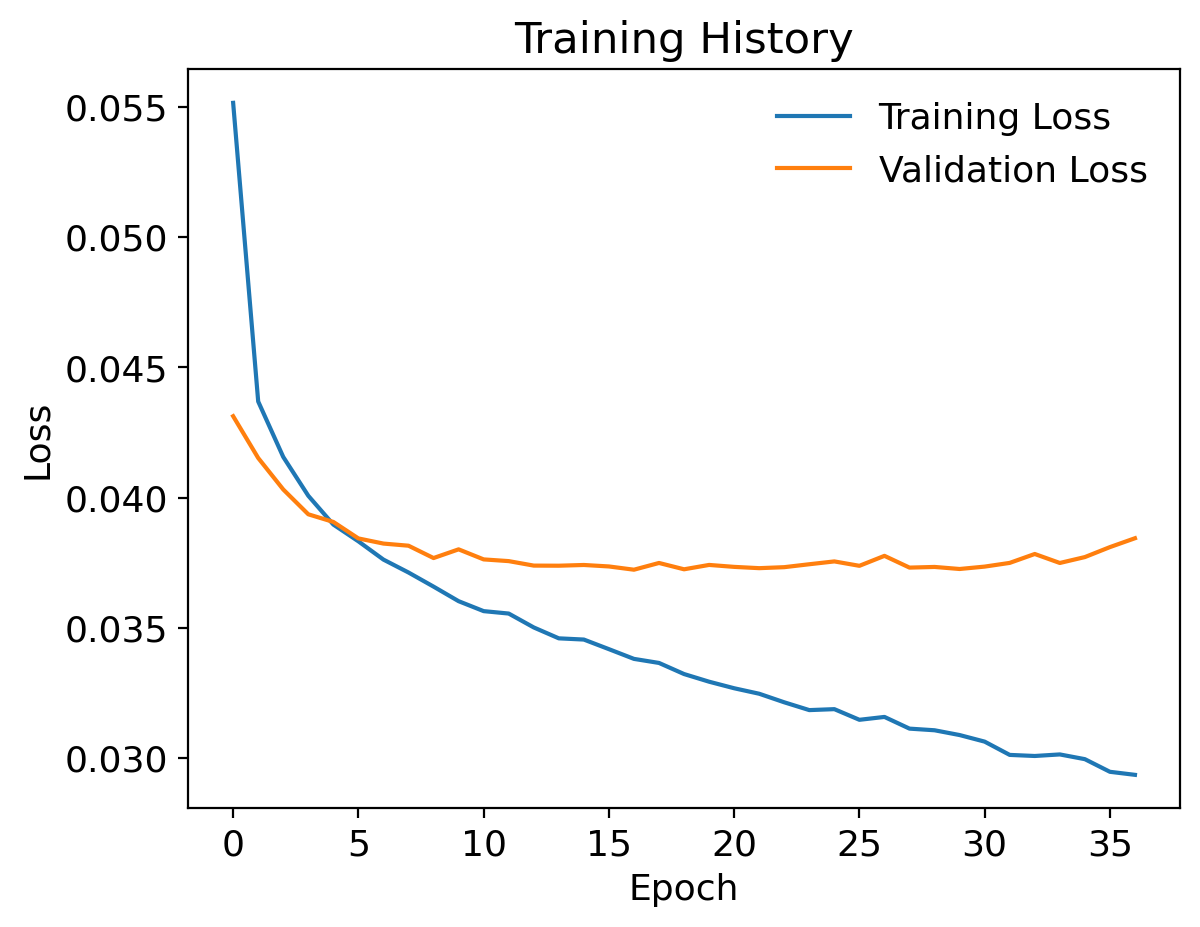

In [360]:
plot_history(train_losses, val_losses)

In [361]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [362]:
# Save the entire model to a pth file.
torch.save(model, os.path.join(model_path, 'NN_model.pth'))

In [363]:
# reload the saved model
model = torch.load(os.path.join(model_path, 'NN_model.pth'), weights_only=False)
model.to(device).eval()

Sequential(
  (0): Linear(in_features=38, out_features=128, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=128, out_features=128, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=128, out_features=12, bias=True)
)

In [364]:
import numpy as np
import pandas as pd
import torch.nn.functional as F

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=minibatch_size, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
   for batch_X, in test_loader:
       batch_X = batch_X.to(device)
       outputs = model(batch_X)
       probs = F.softmax(outputs, dim=1)  # apply softmax to get probabilities

       # Convert tensor outputs to CPU and then to list (avoid .numpy())
       predictions.append(outputs.cpu().tolist())

# Concatenate list-of-lists into a single list
import itertools
y_test_pre_list = list(itertools.chain.from_iterable(predictions))

# After prediction and concatenation
y_test_pre = np.concatenate(predictions, axis=0)  # shape (num_samples, 12)

cause_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11']
y_pred_df = pd.DataFrame(y_test_pre, columns=cause_names)


# Evaluation

## RMSE

In [365]:
import numpy as np

# Flatten the DataFrames to 1D arrays (optional but commonly done)
true_values = y_test_df2.values.flatten()
pred_values = y_pred_df.values.flatten()

# Calculate RMSE
rmse = np.sqrt(np.mean((true_values - pred_values) ** 2))
print(f'RMSE: {rmse}')


RMSE: 0.19341447129599085


## Confusion Matrix Total

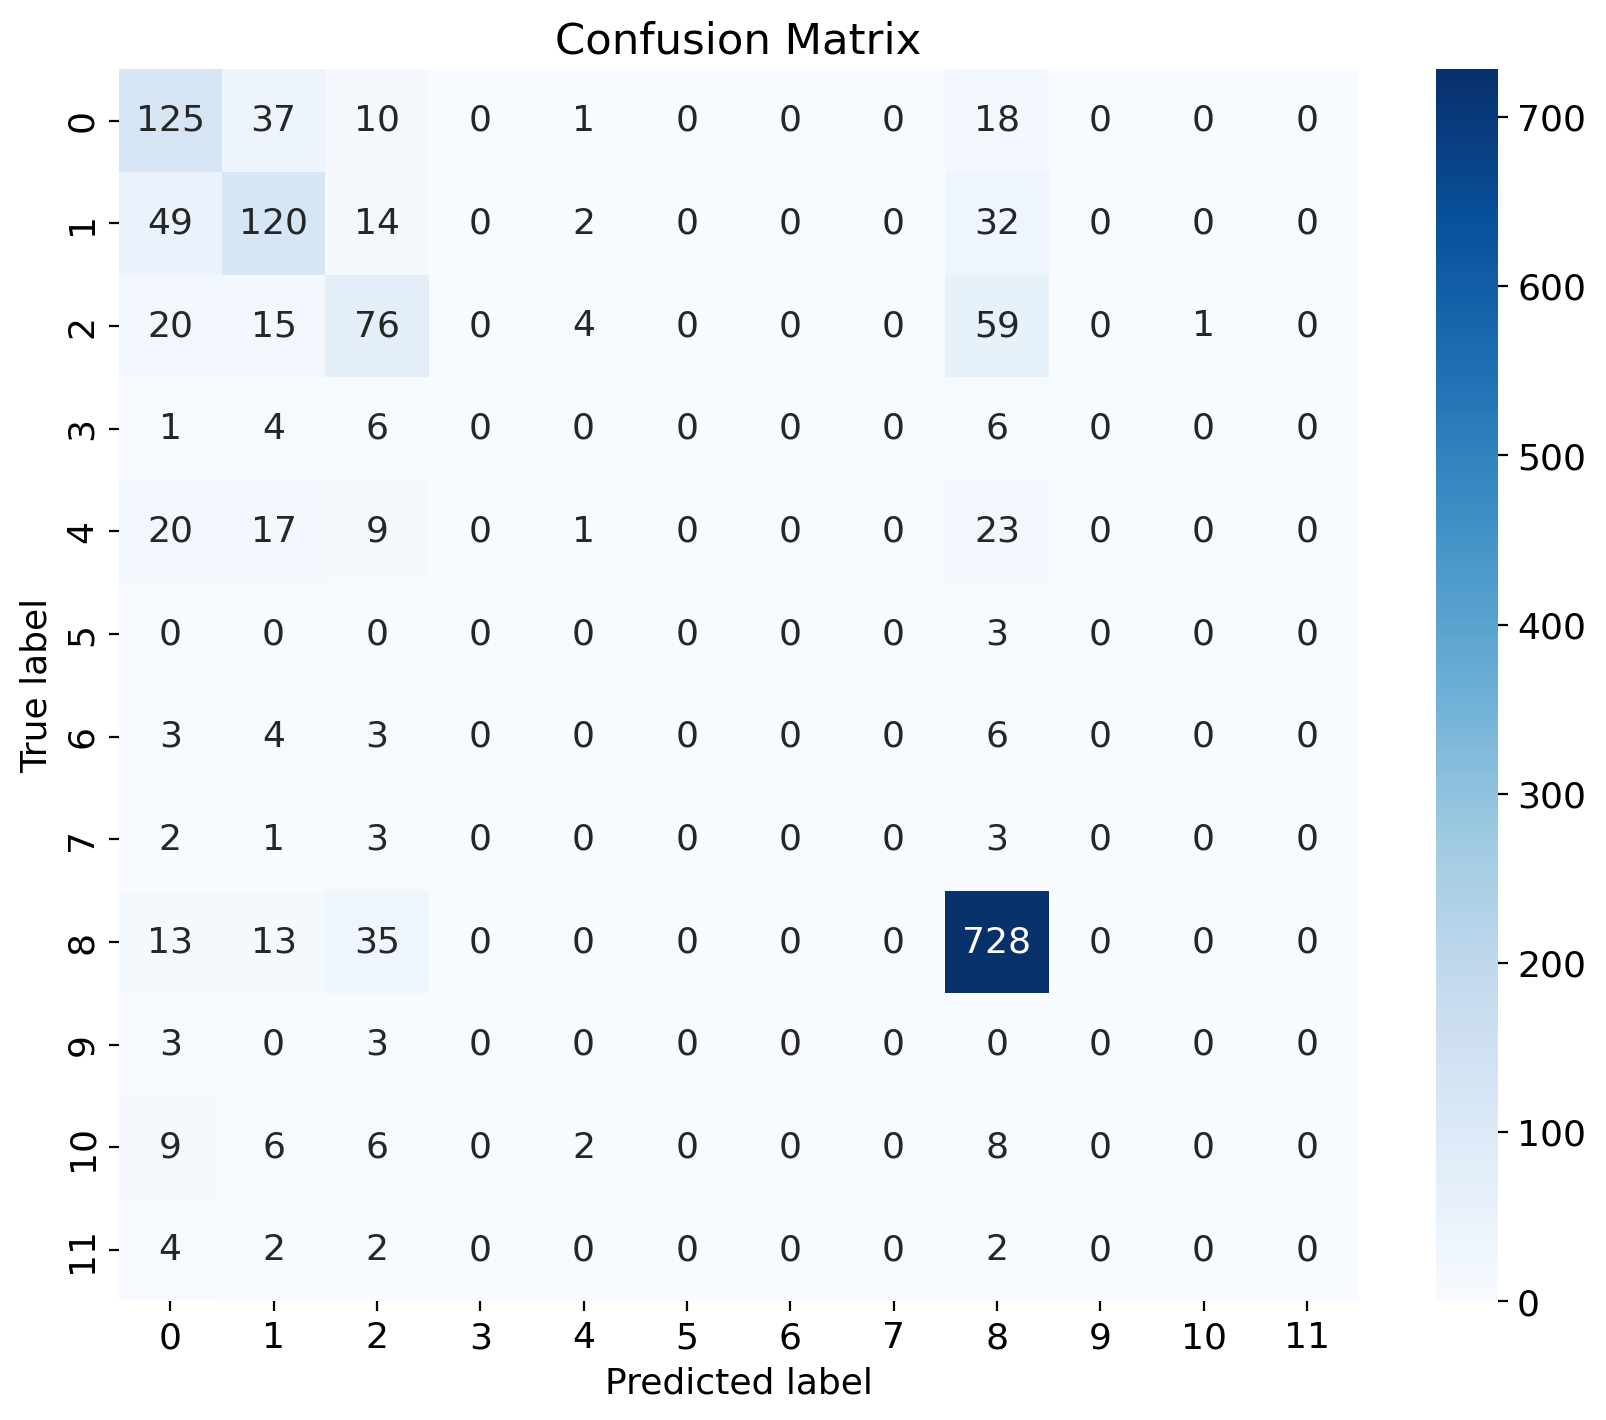

In [366]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# y_test_df and y_pred_df are your dataframes of shape (samples, 12)
# Each row: probabilistic assignment to each cause

# Get true and predicted cause labels by argmax across columns
y_true = np.argmax(y_test_df2.values, axis=1)
y_pred = np.argmax(y_pred_df.values, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=np.arange(12))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


## Confusion Matrix Percentage

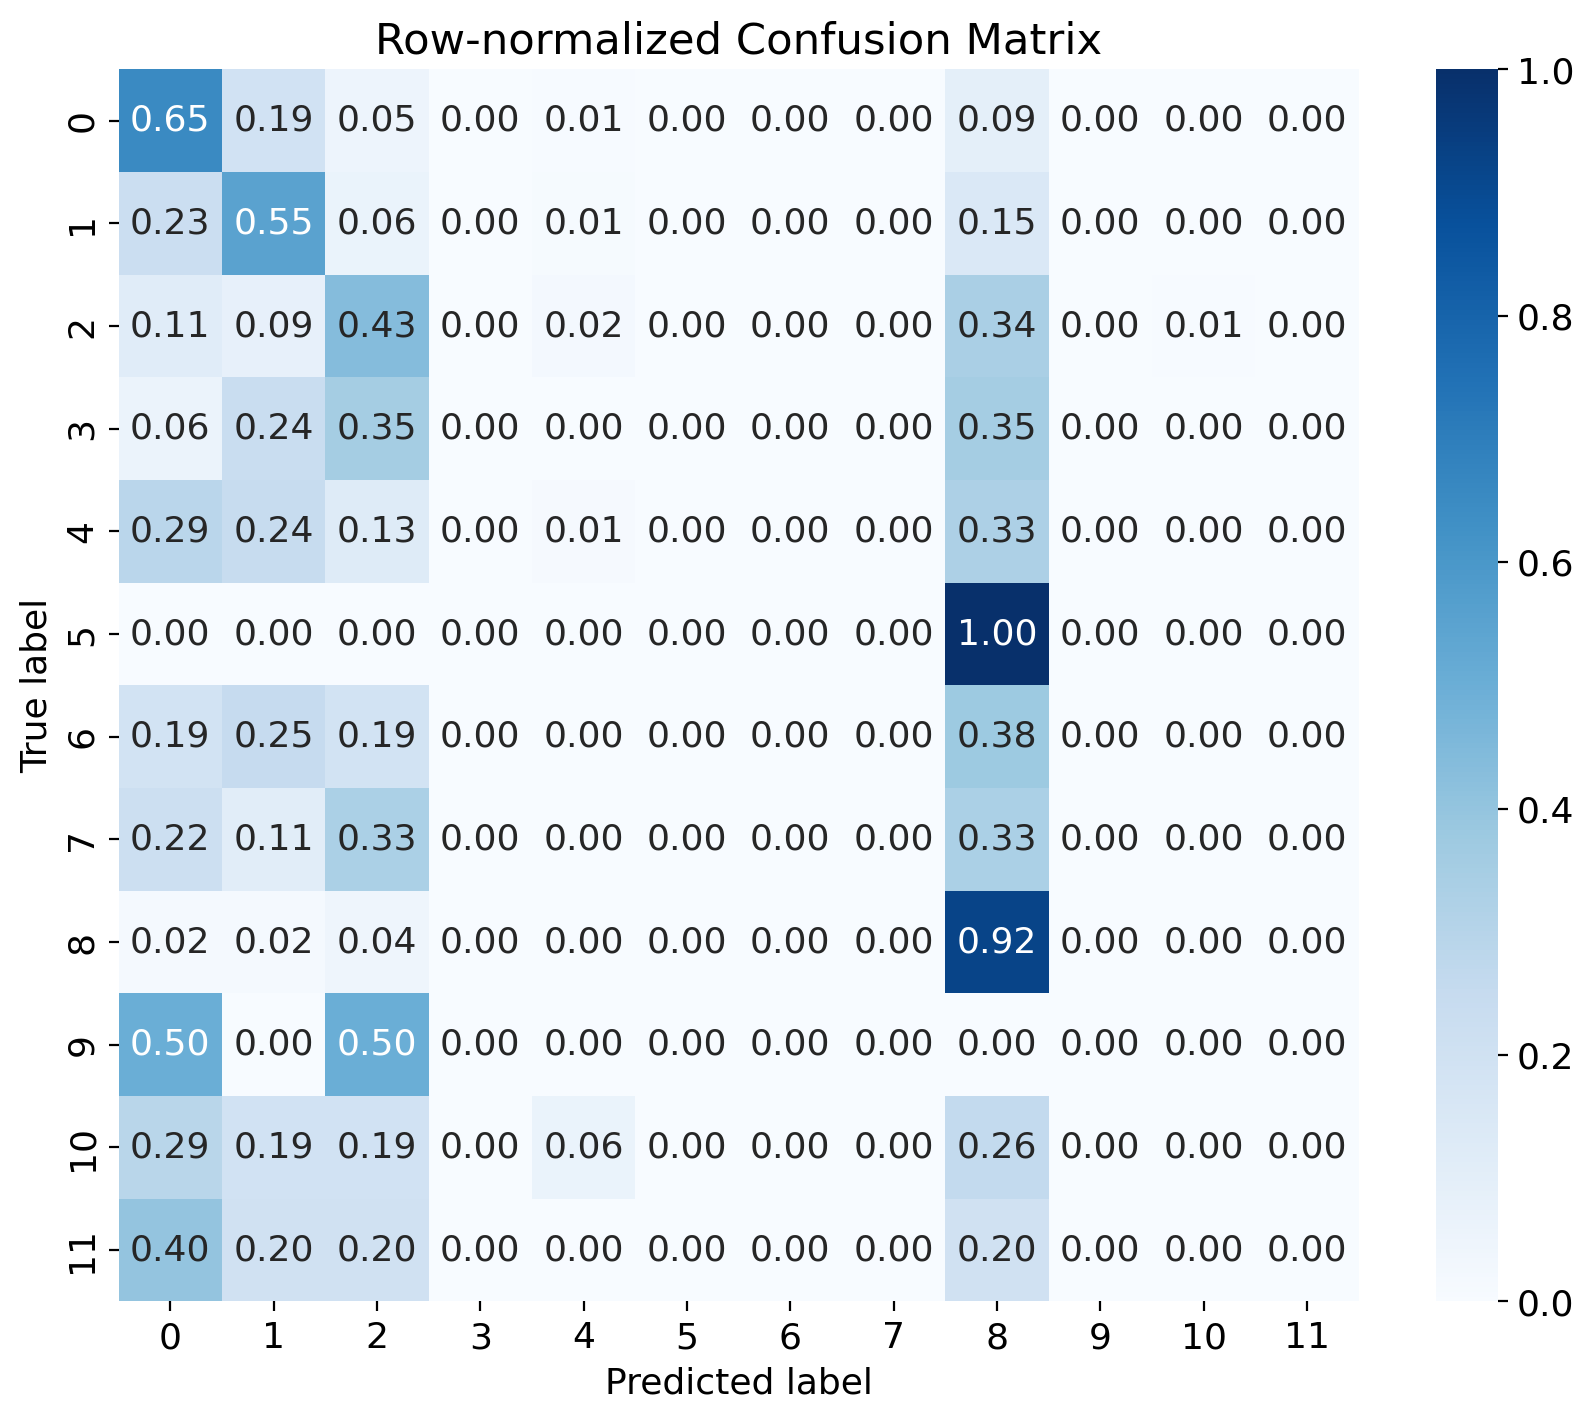

In [367]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Normalize so each row sums to 1 (handle zero rows to avoid division by zero)
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1  # avoid division by zero
cm_normalized = cm / row_sums

# Plot the normalized confusion matrix (values between 0 and 1)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=np.arange(12),
    yticklabels=np.arange(12)
)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Row-normalized Confusion Matrix')
plt.show()


## Accuracy Table

In [368]:
# Calculate accuracy for each category (class-wise accuracy)
class_accuracies = cm.diagonal() / cm.sum(axis=1) *100

# Calculate overall accuracy
overall_accuracy = cm.diagonal().sum() / cm.sum()*100

# Create a DataFrame for better visualization
accuracy_table = pd.DataFrame({
    'Class': np.arange(12),
    'Class Accuracy': class_accuracies
})

# Append overall accuracy as a separate row
overall_row = pd.DataFrame({'Class': ['Overall'], 'Class Accuracy': [overall_accuracy]})
accuracy_table = pd.concat([accuracy_table, overall_row], ignore_index=True)

print(accuracy_table)

      Class  Class Accuracy
0         0       65.445026
1         1       55.299539
2         2       43.428571
3         3        0.000000
4         4        1.428571
5         5        0.000000
6         6        0.000000
7         7        0.000000
8         8       92.268695
9         9        0.000000
10       10        0.000000
11       11        0.000000
12  Overall       68.448501


## All Accuracies

In [369]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# Assuming Natural is index 6, human = all others
natural_idx = 8
y_binary_true = (y_true == natural_idx).astype(int)      # 1 = Natural, 0 = Human
y_binary_pred = (y_pred == natural_idx).astype(int)

print(y_true.shape, y_pred.shape)
print(y_binary_true.shape, y_binary_pred.shape)


# Binary CM: [[TN, FP], [FN, TP]]
cm_binary = confusion_matrix(y_binary_true, y_binary_pred)

# Metrics
binary_accuracy = accuracy_score(y_binary_true, y_binary_pred)
precision_natural = precision_score(y_binary_true, y_binary_pred)
recall_natural = recall_score(y_binary_true, y_binary_pred)
f1_natural = f1_score(y_binary_true, y_binary_pred)

print("Binary CM (Human vs Natural):\n", cm_binary)
print(f"Binary Accuracy: {binary_accuracy:.1%}")
print(f"Natural Precision: {precision_natural:.1%}")
print(f"Natural Recall: {recall_natural:.1%}")
print(f"Natural F1: {f1_natural:.1%}")


#Overall accuracy/recall/precision:
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="weighted", zero_division=0)
rec  = recall_score(y_true, y_pred, average="weighted", zero_division=0)

print(f"Alignment accuracy: {acc:.4f}")
print(f"Recall (weighted):    {rec:.4f}")

print(f"{prec:.4f} & {rec:.4f} & {acc:.4f} & {binary_accuracy:.4f}")


(1534,) (1534,)
(1534,) (1534,)
Binary CM (Human vs Natural):
 [[585 160]
 [ 61 728]]
Binary Accuracy: 85.6%
Natural Precision: 82.0%
Natural Recall: 92.3%
Natural F1: 86.8%
Alignment accuracy: 0.6845
Recall (weighted):    0.6845
0.6182 & 0.6845 & 0.6845 & 0.8559


# Gridsearch

In [354]:
import numpy

def train_evaluate_model(hyperparams, patience=20):
    n_neuron = hyperparams['n_neuron']
    activation = hyperparams['activation']
    learning_rate = hyperparams['learning_rate']
    dropout_p = hyperparams['dropout_p']
    num_epochs = hyperparams['num_epochs']
    weight_decay = hyperparams['weight_decay']
    
    # Build model layers (same as before)
    layers = []
    layers.append(nn.Linear(X_train.shape[1], n_neuron))
    layers.append(getattr(nn, activation)())
    layers.append(nn.Dropout(dropout_p))
    for n in range(N_layers - 1):  # Note: N_layers needs to be defined or passed
        layers.append(nn.Linear(n_neuron, n_neuron))
        layers.append(getattr(nn, activation)())
        layers.append(nn.Dropout(dropout_p))
    layers.append(nn.Linear(n_neuron, y_train.shape[1]))
    model = nn.Sequential(*layers).to(device)
    
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )
    criterion = nn.MSELoss()
    
    best_nat_accuracy = 0.0  # Track best natural vs human accuracy
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training loop (unchanged)
        model.train()
        train_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        
        # Validation with natural vs human accuracy
        model.eval()
# In your training loop, replace the validation part with:
        nat_accuracy = evaluate_natural_accuracy(model, val_loader, natural_idx=8)
        
        if nat_accuracy > best_nat_accuracy:
            best_nat_accuracy = nat_accuracy
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break
    
    return best_nat_accuracy  # Return best natural accuracy instead of loss

def evaluate_natural_accuracy(model, data_loader, natural_idx=8):
    """Pure PyTorch version - no NumPy needed"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            
            # Convert to class predictions
            y_pred = torch.argmax(outputs, dim=1)
            y_true = batch_y.argmax(dim=1) if batch_y.dim() > 1 else batch_y
            
            # Binary: 1 if == natural_idx, else 0
            y_binary_true = (y_true == natural_idx).float()
            y_binary_pred = (y_pred == natural_idx).float()
            
            # Count correct binary predictions
            correct += ((y_binary_true == y_binary_pred).float().sum()).item()
            total += y_true.numel()
    
    return correct / total



In [355]:
import numpy

param_grid = {
    'n_neuron': [16, 32, 64, 128],           # Includes your 32
    'activation': ['ReLU'],                  # Matches yours
    'learning_rate': [0.001, 0.0005, 0.002], # Includes your 0.001
    'dropout_p': [0, 0.05, 0.1, 0.2],        # Includes your 0.05
    'num_epochs': [50],                      # Matches yours
    'weight_decay': [0, 1e-5, 5e-4, 1e-4, 5e-5, 1e-6], # Includes your 1e-6
    'N_layers': [2]                          # CRITICAL: Matches yours
}


best_hyperparams = None
best_accuracy = 0.0  # Changed: maximize accuracy, not minimize loss

for n_neuron in param_grid['n_neuron']:
    for activation in param_grid['activation']:
        for lr in param_grid['learning_rate']:
            for dropout in param_grid['dropout_p']:
                for weight_decay in param_grid['weight_decay']:  # Added nested loop
                    hyperparams = {
                        'n_neuron': n_neuron,
                        'activation': activation,
                        'learning_rate': lr,
                        'dropout_p': dropout,
                        'num_epochs': param_grid['num_epochs'][0],  # Fixed: use param_grid
                        'weight_decay': weight_decay  # Fixed: use loop variable
                    }
                    val_accuracy = train_evaluate_model(hyperparams)  # Returns accuracy now
                    if val_accuracy > best_accuracy:  # Changed: > for maximization
                        best_accuracy = val_accuracy
                        best_hyperparams = hyperparams.copy()

print(f'Best Hyperparams: {best_hyperparams} with Best Accuracy: {best_accuracy:.4f}')


Best Hyperparams: {'n_neuron': 128, 'activation': 'ReLU', 'learning_rate': 0.0005, 'dropout_p': 0.1, 'num_epochs': 50, 'weight_decay': 5e-05} with Best Accuracy: 0.8616
